In [1]:
from typing import Annotated #add some speical things to do 
from typing_extensions import TypedDict  #it tell you to key value relation

from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages

In [2]:
import os 
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
from langchain_groq import ChatGroq
llm=ChatGroq(model="llama3-8b-8192")

In [4]:
from langchain_tavily import TavilySearch
takivly_tool=TavilySearch(max_result=2)
takivly_tool.invoke("What is today news")

{'query': 'What is today news',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.usatoday.com/',
   'title': 'USA TODAY - Breaking News and Latest News Today',
   'content': 'USA TODAY delivers current national and local news, sports, entertainment, finance, technology, and more through award-winning journalism, photos,',
   'score': 0.61057013,
   'raw_content': None},
  {'url': 'https://www.cnn.com/',
   'title': 'CNN: Breaking News, Latest News and Videos',
   'content': 'View the latest news and breaking news today for U.S., world, weather, entertainment, politics and health at CNN.com.',
   'score': 0.33809948,
   'raw_content': None},
  {'url': 'https://www.cbsnews.com/',
   'title': "CBS News | Breaking news, top stories & today's latest headlines",
   'content': 'Top Videos · CBS News Live · CBS News 24/7 · Trump signs budget bill into law · Rescues continue in Texas after deadly floods · Hamas gives response to latest',
   'score'

In [6]:
from langchain_core.tools import tool
from langgraph.types import interrupt,Command

In [23]:
class state(TypedDict):
    messages:Annotated[list,add_messages]

graph_builder=StateGraph(state)

In [24]:
@tool
def human_assitance(query:str):
    """Request assitance from a human."""
    human_response=interrupt({"query":query})
    return human_response["data"]

In [25]:
tools=[takivly_tool,human_assitance]


In [26]:
llm_with_tool=llm.bind_tools(tools)

In [27]:
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langgraph.checkpoint.memory import MemorySaver

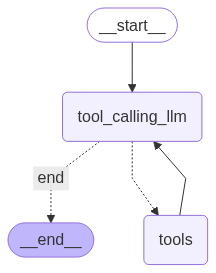

In [28]:
#for memory
memory=MemorySaver()

def tool_calling_llm(state:state):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}
#Nodes
graph_builder.add_node("tool_calling_llm",tool_calling_llm)
graph_builder.add_node("tools",ToolNode(tools))

#edges
graph_builder.add_edge(START,"tool_calling_llm")
def my_tools_condition(state):
    """Custom tools condition that checks for tool calls"""
    messages = state.get("messages", [])
    if not messages:
        return "end"
    
    last_message = messages[-1]
    
    # Check if the last message has tool calls
    if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
        return "tools"
    else:
        return "end"

# Use your custom function
graph_builder.add_conditional_edges(
    "tool_calling_llm",
    my_tools_condition,
    {
        "tools": "tools",
        "end": END
    }
)
graph_builder.add_edge("tools","tool_calling_llm")
graphs=graph_builder.compile(checkpointer=memory)
graphs

In [29]:
config={"configurable":{"thread_id":"1"}}

In [37]:
from langchain_core.messages import SystemMessage, HumanMessage

system_instruction = SystemMessage(content="Respond factually to the user's message. If the user talks about themselves, do not assume they mean someone famous.")
user_message = HumanMessage(content="I need some expert guidance for building AI agent.could you request human assitance for me")


results = graphs.invoke(
    {
        "messages": [system_instruction, user_message]
    },
    config=config  ,
    stream_mode="values"
)
results



{'messages': [SystemMessage(content="Respond factually to the user's message. If the user talks about themselves, do not assume they mean someone famous.", additional_kwargs={}, response_metadata={}, id='213756fa-7da2-4668-a407-cb8f3c21702c'),
  HumanMessage(content='Hi, My name is muhammad Salman', additional_kwargs={}, response_metadata={}, id='4bd642d7-c766-44cd-b7ab-cb96cb6a8d72'),
  AIMessage(content="Hello Muhammad Salman! It's nice to meet you.", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 2191, 'total_tokens': 2203, 'completion_time': 0.021730363, 'prompt_time': 0.385810053, 'queue_time': 0.24087230900000006, 'total_time': 0.407540416}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_8dc6ecaf8e', 'finish_reason': 'stop', 'logprobs': None}, id='run--b65aa648-a221-43bf-a122-08058cb8a29b-0', usage_metadata={'input_tokens': 2191, 'output_tokens': 12, 'total_tokens': 2203}),
  SystemMessage(content="Respond factually t

In [38]:
if "__interrupt__" in results:
    print(" Human assistance required.")
    print(" Tool called with query:", results["__interrupt__"][0]["value"]["query"])

    human_reply = HumanMessage(content="Yes, I want to create a LangGraph-based multi-agent system using LangChain.")

    # Resume graph
    async for step in graphs.stream({"resume": {"data": human_reply}}, config=config, stream_mode="values"):
        print(step)
